# SciML SANUM2024
# Lab 4: Solving differential equations in DifferentialEquations.jl

We now consider the solution of time-evolution ordinary differential equations (ODEs) using the
DifferentialEquations.jl framework. An important feature is the ability to
use automatic-differentiation with the numerical solutions, allowing us to solve
simple nonlinear equations or optimisation problems involving parameters or initial conditions in the ODEs.

**Learning Outcomes**
1. Solving ODEs using DifferentialEquations.jl
2. Differentiating an ODE with respect to parameters or initial conditions.
3. Solving simple nonlinear equations or optimisation problems involving paramters in an ODE.

In [2]:
using DifferentialEquations, Plots, LinearAlgebra, Test
# DifferentialEquations.jl is a "mega" package for solving ODEs, stochastic DEs, etc.

## 4.1 Solving ODEs with DifferentialEquations.jl

DifferentialEquations.jl is a powerful framework for solving many different types of equations with
many different types of solves, including stochastic differential equations, retarded differential equations,
mixed discrete-continuous equations, PDEs,  and more. Here we will focus on the simplest case of second-order
time-evolution ODEs, beginning with the classic pendulum equation.

Consider again the pendulum equation with friction
$$
u'' = τ u' - \sin u
$$
which we rewrite as a first order system:
$$
\begin{bmatrix}
   u' \\
   v'
   \end{bmatrix} = \begin{bmatrix} v \\ -τv - \sin u \end{bmatrix}
$$
We can represent the right-hand side of this equation as a function that writes to a
`du` vector (thus avoiding allocations) as follows:

In [3]:
function pendulum_rhs!(du, 𝐮, τ, t) # τ is a parameter, t is time, du is the derivative
    u,v = 𝐮
    du[1] = v
    du[2] = -τ*v-sin(u)
end

pendulum_rhs! (generic function with 1 method)

Here `τ` plays the role of a parameter: for fast time-stepping its essential that we know the types
at compile time and hence its much better to pass in a parameter than refer to a global variable.
We can now construct a representation of the ODE problem as follows:

In [11]:
τ = 0.1
T = 10.0
u₀,v₀ = 1,10
prob = ODEProblem(pendulum_rhs!, [u₀,v₀], (0.0, T), τ)

ODEProblem with uType Vector{Int64} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 2-element Vector{Int64}:
  1
 10

We can find the solution to the problem as follows:

48-element Vector{Float64}:
  1.0
 10.0
  1.6719536450446184
  9.868244291629681
  2.9010024556865934
  9.656299617355383
  4.396906308188694
  9.575690971125494
  6.361729774470285
  9.515764830348806
  8.537927258912987
  9.123088974058327
 10.77261936406901
  ⋮
 49.493158105523406
  5.255751868755032
 53.34279013666629
  4.512676966545354
 55.921020149319716
  4.653804439919293
 59.50303331187085
  3.8622213899457867
 61.8236011365133
  4.02043296662964
 63.95912630613761
  3.775929113314616

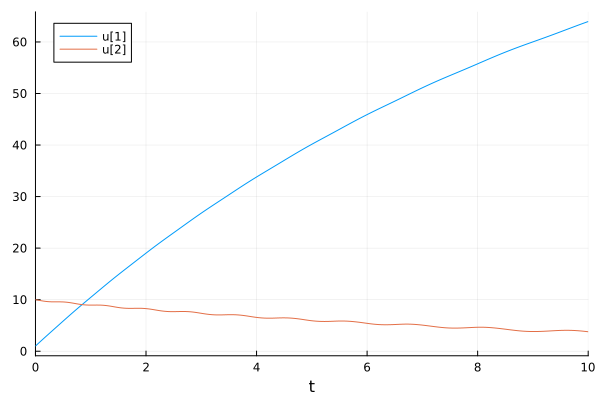

In [12]:
u = solve(prob)
plot(u)

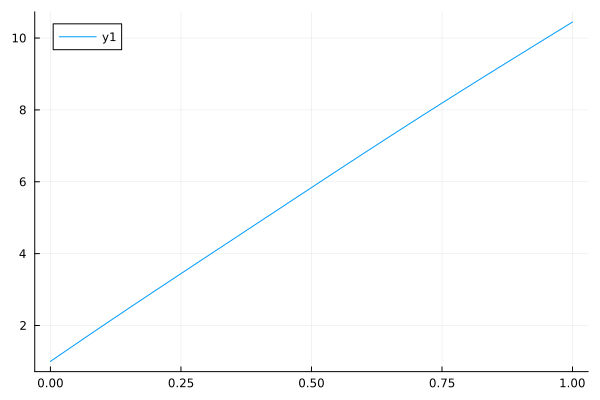

In [18]:
t = range(0, 1; length=100)
plot(t, first.(u.(t)))

In [26]:
ts = u.t # times where we did time steps
us = Vector(u) # values at the ts
(ts, us)

([0.0, 0.06763555592993468, 0.1936417045839942, 0.349467352552951, 0.5548944379687996, 0.7880628433386253, 1.0365126124223853, 1.3777764158760746, 1.7441063055331356, 2.1336458245844803  …  4.427237104396268, 4.977683042631516, 5.4721415181222035, 6.164879116092832, 6.688532166256699, 7.4684871970219975, 8.035451648379372, 8.86637689356164, 9.463771228137496, 10.0], [1.0, 10.0, 1.6719536450446184, 9.868244291629681, 2.9010024556865934, 9.656299617355383, 4.396906308188694, 9.575690971125494, 6.361729774470285, 9.515764830348806  …  53.34279013666629, 4.512676966545354, 55.921020149319716, 4.653804439919293, 59.50303331187085, 3.8622213899457867, 61.8236011365133, 4.02043296662964, 63.95912630613761, 3.775929113314616])

DifferentialEquations.jl has many diferent time-steppers, eg, `Tsit5()` is
an explicit Runge–Kutta method (a more efficient analogue of ode45 in Matlab).
Because we have access to automatic differentiation, we can also easily use implicit methods
(even though they aren't needed here). Here's the same problem using an implicit method\
with tolerances specified:

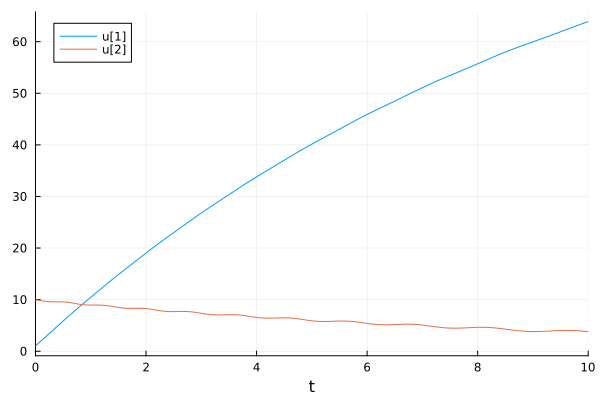

In [28]:
# implicit time-stepper 
u = solve(prob, Rodas4(), abstol=1e-10, reltol=1e-10)
plot(u)

------

**Problem 1** Approximate  a solution to the predator-prey model
$$
\begin{bmatrix} x' \\ y' \end{bmatrix} =  \begin{bmatrix}αx - βxy \\  δxy - γy\end{bmatrix}
$$
on $T ∈ [0,10]$ with $α , β,δ,γ = 1,2,3,4$ with initial condition $[1,2]$.

In [ ]:
function predatorprey_rhs!(du, 𝐮, ps, t)
    (α,β,δ,γ) = ps
    # TODO: Implement the right-hand side for the predator prey model

end

# TODO: use predatorprey_rhs! to setup an ODE and plot the solution

------

## 4.2 Combining auto-differentiation with DifferentialEquations.jl

The combination of automatic-differentiation and time-stepping allows for differentiating
with respect to parameters through an actual solve. For forward-mode automatic differentiation
this is intuitive: the values at each time-step are now dual numbers. Here we see a simple
example using ForwardDiff.jl. Consider the problem of choosing a friction so at the end time
the pendulum is at the bottom (but not necessarily stationary). We can set this up as follows,
where for simplicity we hard-code the initial conditions as $[1,1]$:

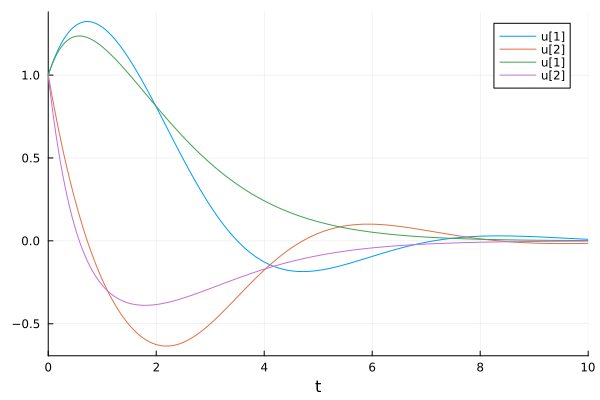

In [31]:
function pendulum_friction(τ)
    T = 10.0
    u₀,v₀ = 1,1
    prob = ODEProblem(pendulum_rhs!, [u₀,v₀], (0.0, T), τ)
    solve(prob)
end

plot(pendulum_friction(1))
plot!(pendulum_friction(2))

In [35]:
pendulum_friction_stop(τ) = pendulum_friction(τ)[end][1] # the last value of position

pendulum_friction_stop(0.1)

-0.2518736728306638

We can immediately differentiate with respect to `τ`:

In [42]:
@time pendulum_friction_stop(0.1)

  0.000239 seconds (322 allocations: 24.078 KiB)


-0.2518736728306638

In [43]:
using ForwardDiff
@time ForwardDiff.derivative(pendulum_friction_stop, 0.1)

  0.000211 seconds (382 allocations: 32.844 KiB)


-1.375294335837402

In [44]:
h = 0.000001;
@time (pendulum_friction_stop(0.1+h)-pendulum_friction_stop(0.1))/h

  0.000239 seconds (647 allocations: 48.203 KiB)


-1.371844924380472

Behind the scenes this is running the time-stepper with dual numbers. We can use this in a simple newton iteration to, for example, find the friction
that results in a desired end conditon:

In [46]:
τ = 0.1 # initial guess
for k = 1:10
    τ = τ - ForwardDiff.derivative(pendulum_friction_stop,τ) \ pendulum_friction_stop(τ)
end
τ

0.03161839779086841

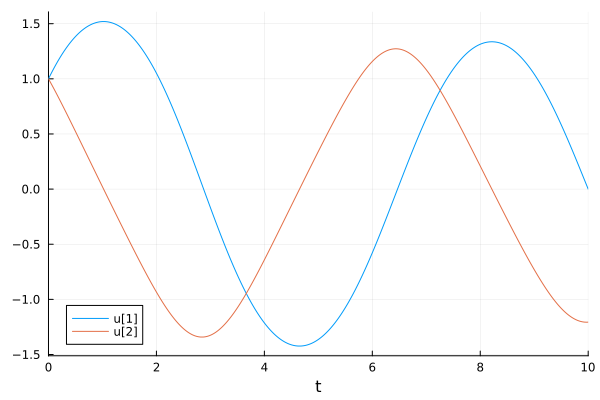

In [47]:
plot(pendulum_friction(τ))

We see that it has successed in finding one such friction so that we end
up at the bottom at the final time:

In [ ]:
#

------

**Problem 2** We can also differentiate with respect to the initial conditions.
Find an initial velocity such that the pendulum is at the bottom at $T = 10$ with
no friction, assuming $u(0) = 1$.

In [ ]:
# TODO: Setup a function taking in the initial velocity and find the initial velocity so we end at rest.

**Problem 3** We can also compute gradients and Jacobians through solves using
forward-mode autmatic differentiation. For the predator and prey model, fix $α = γ = 1$
and initial conditions $x(0) = 1$, $y(0) = 2$.
Use automatic differentiation with vector Newton iteration  to choose
choose $β,δ$ so that $x(10) = y(10) = 1$.

In [ ]:
# TODO: find the parameters in predator and prey to reach the desired end condition

------

## 4.3 Automatic-differentiation of ODEs with Zygote.jl

Zygote.jl also works with automatic differentation, but it requires another package: SciMLSensitivity.
Here is an example of computing the derivative. The catch is its more restrictive, in particular it requires that
the parameters are specified by a vector:

In [57]:
using Zygote, SciMLSensitivity # SciMLSensitivity supports Zygote+DiffEq

function pendulum_rhs_zygote!(du, 𝐮, τv, t) # τv isa AbstractVector to work with Zygote
    u,v = 𝐮
    τ = τv[1]
    # if Zygote were using reverse-mode, this wouldn't work since its modifying a vector
    du[1] = v 
    du[2] = -sin(u) - τ*v
end

function pendulum_friction_zygote(τ)
    T = 10.0
    u₀,v₀ = 1.0,1.0
    prob = ODEProblem(pendulum_rhs_zygote!, [u₀,v₀], (0.0, T), [τ])
    solve(prob)
end
pendulum_friction_zygote_stop(τ) = pendulum_friction_zygote(τ)[end][1]

pendulum_friction_zygote_stop (generic function with 1 method)

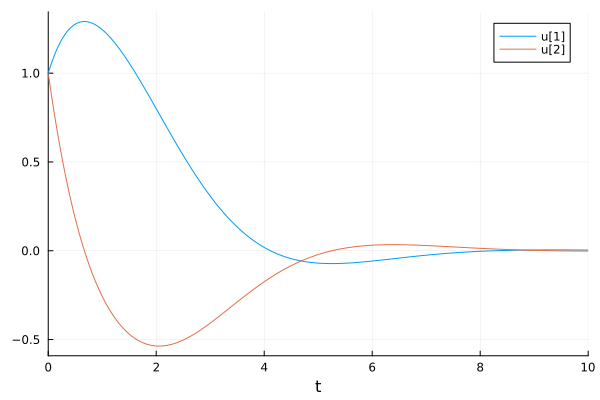

In [58]:
plot(pendulum_friction_zygote(1.3))

In [62]:
@time pendulum_friction_zygote_stop'(0.1);
@time ForwardDiff.derivative(pendulum_friction_stop, 0.1);

  0.000960 seconds (1.56 k allocations: 111.516 KiB)
  0.000163 seconds (382 allocations: 32.844 KiB)


Now one might ask: how is Zygote.jl computing the derivative with reverse-mode automatic differentiation
when `pendulum_rhs_zygote!` is modifying the input, something we said is not allowed? The answer: its not.
Or more specifically: its computing the derivative (and indeed the pullback) using forward-mode automatic differentation.
But we can still use it for efficiently computing gradients and optimising.

Here is an example of the pendulum equation where we allow for a piecewise-constant frictions and optimise their values so the final solution
has roughly the same position and velocity as we started with. We first setup the problem and show we can
compute gradients:

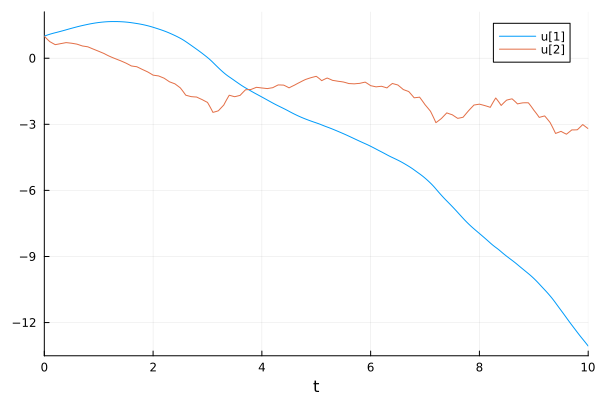

In [87]:
function pendulum_rhs_zygote_vec!(du, 𝐮, τs, t) # τs is a vector of different frictions
    # each friction will be in a window of size 0.1
    u,v = 𝐮
    τ = τs[max(1,ceil(Int,10t))]
    # if Zygote were using reverse-mode, this wouldn't work since its modifying a vector
    du[1] = v 
    du[2] = -sin(u) - τ*v
end

function pendulum_friction_zygote_vec(τs)
    T = 10.0
    u₀,v₀ = 1.0,1.0
    prob = ODEProblem(pendulum_rhs_zygote_vec!, [u₀,v₀], (0.0, T), τs)
    solve(prob, Vern9(), abstol=1E-10, reltol=1E-10)
end

pendulum_friction_zygote_vec_stop(τs) = pendulum_friction_zygote_vec(τs)[end][1]

plot(pendulum_friction_zygote_vec(randn(100)))


In [82]:
x = randn(100)
pendulum_friction_zygote_vec_stop(x)

9.587097826781571

This can then be used an optimisation:

In [100]:
# ignore second argumet of parameters
pendulum_friction_loss(τs, p) = norm(pendulum_friction_zygote_vec(τs)[end] .- 1)^2

τs = randn(100)
gradient(pendulum_friction_loss, τs, ())[1]

100-element Vector{Float64}:
 -80.20200194914682
 -64.37629958178381
 -49.56518344676406
 -36.31582234134724
 -25.047717351246618
 -15.699851534424177
  -8.473850802403529
  -3.427976453353884
  -0.4769741109403755
   0.4183794754087454
  -0.6937801174700353
  -3.9578885464372706
  -9.353135476979569
   ⋮
  -2.072275659184715
  -1.7555593107365128
  -1.4892750914053128
  -1.26034897099912
  -1.0745414277481056
  -0.9174464838988331
  -0.7702771052176077
  -0.63205845823548
  -0.5101584105020562
  -0.398132068340979
  -0.29724649057969826
  -0.19633054974578631

In [101]:
using Optimization, OptimizationOptimisers
x = randn(100) # initial guess
prob = OptimizationProblem(OptimizationFunction(pendulum_friction_loss, AutoZygote()),
      x, ()) # last () means no parameters
@time ret = solve(prob, Adam(0.03), maxiters=200)

  6.626647 seconds (76.73 M allocations: 3.409 GiB, 3.33% gc time, 2.10% compilation time: 25% of which was recompilation)


retcode: Default
u: 100-element Vector{Float64}:
  0.5152193046388641
  0.4780169912632559
 -1.317355470531518
  0.25620741109551154
 -2.239126916777536
 -0.5459666405133323
 -2.346485628187348
  1.0754527146810022
 -0.9131927081220771
 -0.777893430300094
  0.8380947016709087
  0.6630530174669683
  0.21295381556215728
  ⋮
 -1.1431120940122057
 -0.29159585525329673
 -1.5143626648949735
 -1.8242776794627817
 -0.6037956490116243
 -1.8549159530352501
 -2.0460113706347247
 -0.9159140406701137
 -0.04552530400087255
 -0.2607990645264959
 -0.24704741465561397
 -1.1453584853197472

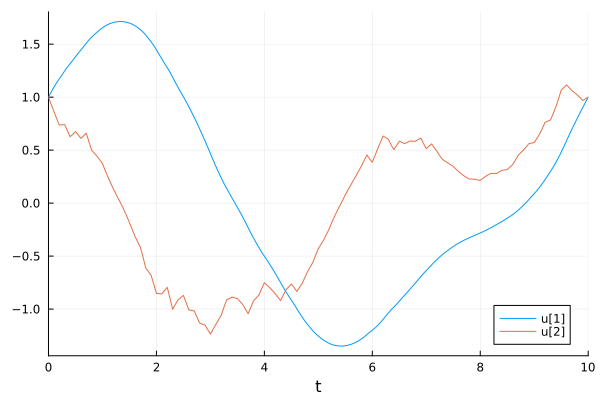

In [102]:
τs = ret.u
plot(pendulum_friction_zygote_vec(τs))

**Problem 4** For the predator-prey model, Choose $α,β,γ,δ$ to try to minimize the 2-norm of $x(t) - 1$ evaluated at
the integer samples $t = 1,…,10$ using the initial condition $[x(0),y(0)] = [2,1]$. Hint: using `u = solve(...; saveat=1:10)` will cause `Vector(u)` to contain the solution
at the specified times. Different initial guesses will find different local minimum.

In [ ]:
# SOLUTION


function predatorprey(ps)
    prob = ODEProblem(predatorprey_rhs!, [2.,1.], (0.0, 10.0), ps)
    solve(prob, Tsit5(), abstol = 1e-10, reltol = 1e-10, saveat=1:10)
end

function predatorprey_norm(ps, _)
    u = predatorprey(ps)
    norm(first.(Vector(u)) .- 1)
end

prob = OptimizationProblem(OptimizationFunction(predatorprey_norm, Optimization.AutoZygote()), [1.0,0.1,0.1,1], ())
@time ret = solve(prob, Adam(0.03), maxiters=300)
plot(predatorprey(ret.u))


## END

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*